## Reanalysis of TnSeq data

In this notebook, I verify predictions from simulated fitness assays and error estimates using data from my transposon sequencing project on the Long-term evolution experiment. Because we went overboard with sequencing depth, and had multiple timepoints in my analysis, I can downsample data or use fewer timepoints and explore how that changes error estimates. 

In addition, I performed fitness assays for the LTEE ancestor in LB (with 10 generations per day). This allows me to potentially explore whether in log2(100) generations vs 10 generations per day impacts measurement error.

In [276]:
#importing libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns
import pathlib
import os
from scipy.stats import gaussian_kde


In [2]:
sns.set_theme()
sns.set_context('paper')
sns.set_style('ticks')

In [3]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays/AnalysisNotebooks


In [4]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the fitness trajectories data
path = pathlib.Path(cwd)
repo = str(path.parents[0])
print(path.parents[0]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays


In [5]:
#paths for metadat and mutant trajectories
metadata_path = repo+'/Metadata/'
data_path = repo+'/ProcessedData/Mutant_Trajectories/'

In [175]:
#names of libraries
libraries = ['REL606']
#more interpretable names for the figures in the paper
libraries2 = ['Anc']

In [7]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]

#genomic coordinates of pseudogenes
locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')

In [8]:
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

#reading the REL606 reference genome
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in the interior of each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle of the gene, excluding defined fractions at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

### Here, I want to compare how measurement error varies with true fitness; for this calculation, I will restrict analysis to trajectories that survive to the end of the assay.

Reasoning: because we add a pseudocount for trajectories that die out at the first appearance of a zero, fitnesses for essential genes may appear more accurate than they actually are (we're basically doing log(x/1)/6.64, where x is quite similar for the TA sites within the gene)

In [176]:
#all the information from the fitness assay condensed into a couple of matrices
counts_all_green = np.zeros([len(libraries), 5, len(ta_sites)])
counts_all_red = np.zeros([len(libraries), 5, len(ta_sites)])

for k in range(len(libraries)):
    #loading the new file where I have the counts for each TA site for all time points
    gname = data_path+'green_'+libraries[k]+'_merged_all_TAsites.txt'
    greendata = np.loadtxt(gname)
    rname = data_path+'red_'+libraries[k]+'_merged_all_TAsites.txt'
    reddata = np.loadtxt(rname)
    #now for extracting the UMI corrected coutns
    counts_all_green[k,:,:] = greendata[2:11:2,:]
    counts_all_red[k,:,:] = reddata[2:11:2,:]

In [177]:
#normalized counts data for each sample:
greensum = np.sum(counts_all_green,axis=2)
redsum = np.sum(counts_all_red, axis=2)

### Defining some important functions:

`search_gene`: Returns a mask corresponding to sites in the interior of a gene

`fitness_estimate`: Calculates fitness estimates and errors from counts data for all genes

`downsample`: Downsamples counts data by a specified fold reduction

In [180]:
def search_gene(locations,ta_sites,i):
    """
    Input: 
    locations: gene coordinates, start, end and orientation
    ta_sites: list of TA sites
    i: query gene
    
    Returns:
    mask corresponding to the interior of the 'i'th gene in the E. coli genome
    """
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
    #if the gene is on the reverse strand
    elif locations[i,2]==-1:
        search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
    return search_area

In [160]:
#calculating fitnesses
def fitness_estimate(counts_red, counts_green, locs, genes_lost, initial_depth, min_sites, min_frac, max_reads, t_start, t_end):
    """
    data:
    - counts_red, counts_green: trajectories for both replicates
    - exclude: filtering out genes that are lost/have too few sites from analysis as they're indicated as -1
    params:
    - locs: start and end points of genes
    - initial_depth: exclude sites below a certain threshold in fitness estimation
    - min_sites: minimum number of sites required for estimating fitness for each replicate
    - min_frac: fraction of TA sites that need to considered in estimating fitness
    - site_thresh: minimum number of reads for a trajectory to be included (strictly greater than)
    - max_reads: maximum reads that can be used for inverse variance estimate
    
    """
    green = np.sum(counts_green,axis=1)
    red = np.sum(counts_red, axis=1)
    #fitness effect (best estimate)
    fitness_inverse_var = np.zeros([len(genes_lost),2])-1
    #three different metrics of measurement error
    stderr_fitness_inverse_var = np.zeros([len(genes_lost)])-1
    #defining time interval based on gene essentiality status:
    time_gens = np.linspace(t_start,t_end,t_end-t_start+1)*6.64
    
    #iterating over all genes that are not lost over evolution
    for gene in np.where(genes_lost==0)[0] :
        #TA sites within this gene
        search_area = search_gene(locations=locs, ta_sites=ta_sites, i=gene)
        #weights
        weights_green = []
        weights_red = []
        #fitnesses
        s_green = []
        s_red = []
        
        ta = np.sum(search_area==True)
        #now, iterating over sites with at least tm1_depth reads at the start of the assay:
        for j in np.where((search_area==True))[0]:
            if (counts_green[t_start,j]/green[t_start]*10**7>initial_depth) & (counts_red[t_start,j]/red[t_start]*10**7>initial_depth):
                #extracting the trajectories
                traj_green = counts_green[t_start:t_end+1,j]/green[t_start:t_end+1]*10**7
                traj_red = counts_red[t_start:t_end+1,j]/red[t_start:t_end+1]*10**7
                n_before_g = traj_green[t_start]
                n_before_r = traj_red[t_start]
                n_after_g = traj_green[t_start+1]
                n_after_r = traj_red[t_start+1]
                
                #green replicate first
                if np.min(traj_green):
                    sg = np.polyfit(time_gens, np.log(traj_green), 1)[0]
                    wg = min(inverse_var_weight(n_before_g, n_after_g), inverse_var_weight(max_reads, max_reads))
                    #sotring the data
                    weights_green.append(wg)
                    s_green.append(sg)
                
                #now the red replicate
                if np.min(traj_red):
                    sr = np.polyfit(time_gens, np.log(traj_red), 1)[0]
                    wr = min(inverse_var_weight(n_before_r, n_after_r), inverse_var_weight(max_reads, max_reads))
                    #sotring the data
                    weights_red.append(wr)
                    s_red.append(sr)
        
        #converting to numpy arrays
        s_green = np.array(s_green)
        s_red = np.array(s_red)
        weights_green = np.array(weights_green)
        weights_red = np.array(weights_red)
        
        #pooling over all sites, require minimum number of sites, and fraction of sites represented
        if min(len(s_green),len(s_red))>=min_sites and min(len(s_green),len(s_red))/ta>=min_frac:

            #weighing based on inverse variacne:
            fitness_inverse_var[gene,0] = np.average(s_green, weights=weights_green)
            fitness_inverse_var[gene,1] = np.average(s_red, weights=weights_red)
            
            #inverse variance weighted standard error measurement
            stacked_s = np.hstack([s_green,s_red])
            stacked_w = np.hstack([weights_green,weights_red])
            average = np.average(stacked_s, weights=stacked_w)
            #inverse variance weighted sem
            sem_inv = np.sqrt(np.average((stacked_s-average)**2, weights=stacked_w)/(len(stacked_s)-1))
            #saving the inverse variance wieghted measurements.
            stderr_fitness_inverse_var[gene] = sem_inv
            
    return fitness_inverse_var, stderr_fitness_inverse_var


In [361]:
#calculating fitnesses
def fitness_site(counts_red, counts_green, locs, genes_lost, initial_depth, t_start, t_end):
    #select insertion mutations with at least a minimum number of reads at the start:
    green = np.sum(counts_green,axis=1)
    red = np.sum(counts_red, axis=1)
    #initial depth is above threshold
    condition1 = counts_green[t_start,:]/green[t_start]*10**7>initial_depth
    condition2 = counts_red[t_start,:]/red[t_start]*10**7>initial_depth
    #trajectories do not die out
    condition3 = np.min(counts_green[t_start:t_end+1, :], axis=0) > 0
    condition4 = np.min(counts_red[t_start:t_end+1, :], axis=0) > 0
    nonzero_sites = np.where(condition1 & condition2 & condition3 & condition4)[0]
#     print(nonzero_sites, len(nonzero_sites))
    
    fitnesses = []
    
    #defining time interval based on gene essentiality status:
    time_gens = np.linspace(t_start,t_end,t_end-t_start+1)*6.64
    #iterate over each site and calculate fitness:
    for site in nonzero_sites:
        traj_green = counts_green[:t_end+1, site]
        traj_red = counts_red[:t_end+1, site]
#         print(traj_green)
        fitnesses.append((np.polyfit(time_gens[:t_end+1], np.log(traj_green), 1)[0] + np.polyfit(time_gens[:t_end+1], np.log(traj_red), 1)[0])*0.5)
    
    return fitnesses
    

In [179]:
def downsample(data, scale):
    """
    Inputs: 
    - data: counts matrix for bulk fitness assay
    - scale: scaling factor for downsampling, must be greater than 1.
    
    Process:
    - downsample number of reads mapping to an insertion site as follows (for each time point, here: by row)
    - use np.repeat to get an list with every insertion site repeated N times, where N is the number of mapped reads
    - use np.shuffle to rearrange this list
    - pick the first 1/scale fraction of this list
    - use np.unique to which sites are represented, and how frequently after downsampling.
    
    Output:
    - data_scaled: same shape as data but each row of the matrix downsampled by the scaling factor
    """
    assert scale >= 1, f"downsampling scale factor must be greater than/equal 1"
    
    if scale == 1: #do not downsample the data at all:
        return data
    
    else:
        data_scaled = np.zeros_like(data)

        for t in range(data.shape[0]): #there are 5 timepoints in the data
            #this is the key step in the process, every TA site is repeated as many times as number of reads mapping to it
            explicit_data = np.repeat(np.arange(0,data.shape[1]), data[t,:].astype('int'))
            #this list is then shuffled
            np.random.shuffle(explicit_data)
            #and a subset of this list becomes the new data
            N_ds = int(data.sum(axis=1)[t]/scale)
            #as we shuffled the data, taking the first N_ds reads is equivalent to taking a 1/scale random subset of the data
            downsampled = explicit_data[:N_ds]
            #getting the counts and unique TA sites represented after downsampling
            unique, counts = np.unique(downsampled, return_counts=True)
            data_scaled[t,unique] = counts
        
        return data_scaled

In [161]:
#parameters for filtering out noisy data and selecting which time points to use in analysis
min_sites = 2
min_frac = 0.2
#timepoints to compare:
# change this depending on the analysis you want to do!
t0 = 0
t1 = 4
time_range = np.linspace(t0,t1,t1-t0+1)*6.64
tm1_depth = 5
max_reads = 100

### Fig 1: Error as a function of true fitness

For this analysis, only using two timepoints of the fitness assay for showing the negative correlation between error and true fitness

In [233]:
fitness_inverse_var_2, pop_error_inv_2 = fitness_estimate(counts_all_green[0], counts_all_red[0], 
                                                           genes_lost=np.zeros(len(names)), locs=locations, initial_depth=tm1_depth,
                                                           min_frac=min_frac,max_reads=max_reads,
                                                           min_sites=min_sites, t_start=0, t_end=1)

In [293]:
genes_analyze = np.where(np.mean(fitness_inverse_var_2,axis=1) > -0.5)[0]
linreg = stats.linregress(np.mean(fitness_inverse_var_2[genes_analyze],axis=1), pop_error_inv_2[genes_analyze])

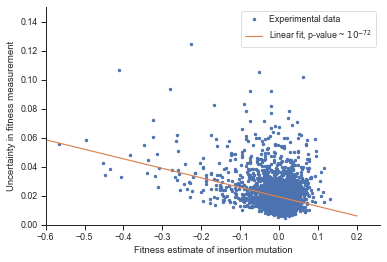

In [303]:
x_range = np.linspace(-0.6, 0.2, 100)
plt.plot(np.mean(fitness_inverse_var_2,axis=1), pop_error_inv_2, '.', label='Experimental data')
plt.plot(x_range, x_range*linreg.slope+linreg.intercept, label='Linear fit, p-value ~ $ 10^{-72}$')
plt.xlabel('Fitness estimate of insertion mutation')
plt.ylabel('Uncertainty in fitness measurement')
plt.legend()
plt.xlim(-0.6)
plt.ylim(0, 0.15)
sns.despine()

In [296]:
print('p-value of linear regression', linreg.pvalue)

p-value of linear regression 1.241671638276303e-72


In [289]:
bins = [-0.6, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05]
error_mean = np.zeros(7)
genes_per_bin = np.zeros(7)
for i in range(len(error_mean)):
    fitness_range = np.mean(fitness_inverse_var_2,axis=1)
    genes_select = np.where((fitness_range>bins[i])&(fitness_range<bins[i+1]))[0]
    error_mean[i] = np.mean(pop_error_inv_2[genes_select])
    genes_per_bin[i] = len(genes_select)

In [290]:
genes_per_bin

array([  27.,   13.,   32.,   55.,  175., 1261., 1613.])

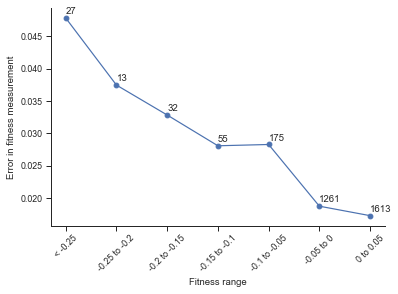

In [291]:
labels = ['< -0.25', '-0.25 to -0.2', '-0.2 to -0.15', '-0.15 to -0.1', '-0.1 to -0.05', '-0.05 to 0', '0 to 0.05']
plt.plot(labels, error_mean, marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel('Fitness range')
plt.ylabel('Error in fitness measurement')
for i, descr in enumerate(genes_per_bin):
    plt.annotate(int(descr), (labels[i], error_mean[i] + 0.0006))
sns.despine()
plt.show()

### Fig 2: Impact of experimental parameters on near-neutral fitness estimates

- sequencing depth
- number of bottlenecks

Other params:
- for reanalysis, consider genes within 5% of neutrality as neutral

In [485]:
scaling_range = 1/np.logspace(-2,0,9)
days_range = np.linspace(2,5,4).astype('int')
s_neut = 0.05

In [486]:
#matrix for storing the error data
error_scaling_days = np.zeros([len(scaling_range),len(days_range)])
most_del = np.zeros([len(scaling_range),len(days_range)])

In [487]:
for i in range(len(scaling_range)):
    scale = scaling_range[i]
    scaled_data_red = downsample(counts_all_red[0], scale)
    scaled_data_green = downsample(counts_all_green[0], scale)
    for j in range(len(days_range)):
        days = days_range[j]
        #now run the fitness calculator function;
        #an important parameter is initial_depth: should be somewhat scaling with total coverage, but set a minimum
        #my approach:
        fitnesses, errors = fitness_estimate(scaled_data_green, scaled_data_red, 
                                             genes_lost=np.zeros(len(names)), locs=locations, 
                                             initial_depth=2,
                                             min_frac=0.1,max_reads=max_reads,
                                             min_sites=1, t_start=0, t_end=days-1)
        #slicing data only for neutral genes
        neutral = np.where(np.abs(np.mean(fitnesses, axis=1))<s_neut)[0]
        error_scaling_days[i,j] = np.mean(errors[neutral])
        #most deleterious mutations
        most_del[i,j] = np.mean(np.sort(np.mean(fitnesses, axis=1)[np.mean(fitnesses, axis=1)>-1])[:10])

In [488]:
np.mean(np.sort(np.mean(fitnesses, axis=1)[np.mean(fitnesses, axis=1)>-1])[:10])

-0.14031320529147623

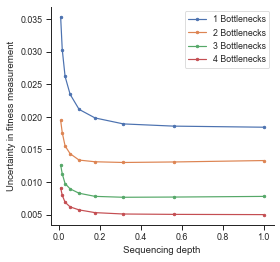

In [489]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    for i in range(len(days_range)):
        plt.plot(1/scaling_range[:], error_scaling_days[:, i], '.-', label=f'{days_range[i]-1} Bottlenecks')
        plt.xlabel('Sequencing depth')
        plt.ylabel('Uncertainty in fitness measurement')
    plt.legend(loc=0)
    sns.despine()
    plt.show()

Discuss with Michael how to make this figure work

### Fig 3/4: Resolution of deleterious fitness effects depends on the sequencing depth and number of bottlenecks

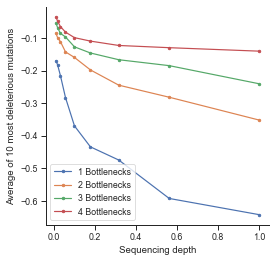

In [472]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    for i in range(len(days_range)):
        plt.plot(1/scaling_range, most_del[:, i], '.-', label=f'{days_range[i]-1} Bottlenecks')
        plt.xlabel('Sequencing depth')
        plt.ylabel('Average of 10 most deleterious mutations')
    plt.legend(loc=0)
    sns.despine()
    plt.show()